In [64]:
 pip install -Uq langgraph langsmith langchain_groq langchain_tavily grandalf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.5 MB/s eta 0:00:00


In [6]:
from os import environ
from google.colab import userdata

environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')
environ["LANGSMITH_API_KEY"] = userdata.get('LANGSMITH_API_KEY')

environ["LANGCHAIN_TRACING_V2"] = "true"
environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
environ["LANGCHAIN_PROJECT"] = "03-LangGraph-Agent"

In [7]:
# 도구
from langchain_tavily import TavilySearch

# 검색 도구 생성
search = TavilySearch(max_results=3)

# 도구 목록에 추가
tools = [search]

In [12]:
search.invoke("에이전트란?")["results"]

[{'url': 'https://help.salesforce.com/s/articleView?id=ai.copilot_overview.htm&language=ko&type=5',
  'title': '에이전트란?',
  'content': '에이전트는 작업 및 비즈니스를 수행하고 데이터를 기반으로 의사결정을 하는 목표지향적 자율형 AI 도우미입니다. 에이전트에 대해 자세히 알아보고 Einstein Bots와',
  'score': 0.8934678,
  'raw_content': None},
 {'url': 'https://seonh.tistory.com/26',
  'title': '데이터공부#2 에이전트(Agent)란 무엇인가? - relax, tiger - 티스토리',
  'content': '① 에이전트는 특정 목적에 대해 사용자를 대신하여 작업을 수행하는 자율적 프로세스(autonomous process)이다. ② 에이전트는 독자적으로 존재하지 않고',
  'score': 0.8335554,
  'raw_content': None},
 {'url': 'https://wikidocs.net/120358',
  'title': 'agent (에이전트) - 인공지능(AI) & 머신러닝(ML) 사전 - 위키독스',
  'content': 'Agent는 인공지능(AI)에서 환경과 상호작용하며 목표를 달성하기 위해 행동을 수행하는 자율적인 시스템 또는 엔터티를 의미한다. 이러한 에이전트는 주어진 환경에서',
  'score': 0.81595254,
  'raw_content': None}]

In [13]:
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

class State(TypedDict):
  messages: Annotated[list, add_messages]

In [17]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="openai/gpt-oss-20b")
llm_with_tools = llm.bind_tools(tools)

In [45]:
def chatbot(state: State) -> State:
  answer = llm_with_tools.invoke(state["messages"])
  return State(messages=[answer])

In [50]:
# 도구 노드(Tool Node)
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode([search])

In [76]:
from langgraph.graph import StateGraph, END

# 그래프 작성
graph_builder = StateGraph(State)
graph_builder.add_node("llm", chatbot)
graph_builder.add_conditional_edges("llm", tools_condition, {"tools": "tools", END: END}) # llm -> tools or END
graph_builder.add_node("tools", tool_node)
graph_builder.add_edge("tools", "llm") # tools -> llm
graph_builder.set_entry_point("llm") # Start -> llm

In [77]:
graph = graph_builder.compile()

In [78]:
print(graph.get_graph().draw_ascii())

        +-----------+       
        | __start__ |       
        +-----------+       
              *             
              *             
              *             
          +-----+           
          | llm |           
          +-----+*          
          .       *         
        ..         **       
       .             *      
+---------+       +-------+ 
| __end__ |       | tools | 
+---------+       +-------+ 


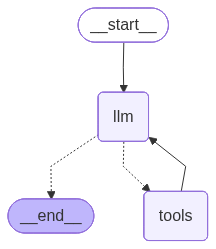

In [81]:
from IPython.display import Image

Image(graph.get_graph(xray=False).draw_mermaid_png())

In [ ]:
inputs = {"messages": [("user", "Agent에 대해서 검색해줘")]}

for event in graph.stream(inputs, stream_mode="values"):
  for key, value in event.items():
    print(f"\n===============\nSTEP: {key}\n===============\n")
    print(value[-1])


STEP: messages

content='Agent에 대해서 검색해줘' additional_kwargs={} response_metadata={} id='7eb8c7cf-7468-4a66-acfd-4a416e97b111'

STEP: messages

content='' additional_kwargs={'reasoning_content': 'The user says "Agent에 대해서 검색해줘" which means "Search about Agent" in Korean. They want a search. We should use tavily_search. We need to set query accordingly. Likely "Agent" is ambiguous. They might want info about "Agent" as a concept? Could be about "agent" in AI context, or "agent" in software. We need to interpret. They didn\'t specify domain or date. We can do a general search. Let\'s search "Agent" with "general" topic. We might want to include images? They didn\'t ask. Just search. We\'ll produce results. Use tavily_search with query "Agent" and maybe include some domain? Not necessary. We\'ll use default search_depth "advanced". Provide results.', 'tool_calls': [{'id': 'fc_72902505-d23a-4b6f-93dd-4b86979e5aa9', 'function': {'arguments': '{"query":"Agent","search_depth":"advanced","topi